In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [1]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json

In [2]:
wikipedia.set_lang("en")  #We make our research in english

## Part1. Corpus builder. Define functions.

In [3]:
def get_all_the_titles(key_words : str,number_of_results):
    ''' 
    function to get the title of pages using wikipedia search with keywords
    
    :param key_words: words to effectuate the wiki research of pages
    
    :param number of results: number of pages the user want to scrap maximum 500
    :type number of results: int
    
    :returns: title of the pages and the number of results
    :rtype: list, int
    '''
    titles = []
    n=str(number_of_results)
    #the url understand + and not space
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit='+n+'&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title']) 
    return titles, nbr_result

In [4]:
def get_section_titles(page : str):
    '''
    Returns the section titles

    :param page: Title of the page
    
    :returns: The list of the titles of the sections
    :rtype: list
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    #find all the headings in the html text 
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4') 
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [5]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results : int, key_for_section : str):
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : words to launch the wikipedia search with
    
    :param number_of_results: number of results the user wants for their corpus maximum 500
    
    :param key_for_section: key words to be found in the titles or in the sections
    
    :returns: a list containing the title of all the pages of the corpus   
    :rtype: list
    '''
    corpus = []
    proper_list = []
    left_list = []
    title_list=[]
    function = get_all_the_titles(word_keys,number_of_results)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    
    for article in tqdm(search_list):
        #create a new list avoiding disambiguation errors
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        #sometimes gets uncategorised errors in that case retry twice then pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
            
    #add to the corpus the article which contains key words in their title
    print("finding pages with key words in the title")
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
    
    #add to the corpus the articles which contains key words in their sections
    print("finding pages with key words in the sections")
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus

## Part1. Corpus builder. Operate.

In [7]:
%%time
#run the corpus selection give the title of each article of the corpus
TOI = "Effects of climate change"
search_list = corpus_selection(word_keys = TOI,number_of_results = 5000, key_for_section ='climate change')
search_list

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20020.54it/s]


finding pages with key words in the title


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 19939.64it/s]


finding pages with key words in the sections


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]

Wall time: 2.69 s


['Effects of climate change',
 'Climate change',
 'Effects of climate change on agriculture',
 'Effects of climate change on human health',
 'Effects of climate change on ecosystems',
 'Effects of climate change on oceans',
 'Climate change in Turkey',
 'Effects of climate change on the water cycle',
 'Climate change in Australia',
 'Effects of climate change on livestock',
 'Effects of climate change on plant biodiversity',
 'Climate change in the United States',
 'Climate change mitigation',
 'Climate change in South Africa',
 'Climate change in Europe',
 'Climate change adaptation',
 'Economic impacts of climate change',
 'Climate change in the United Kingdom',
 'Savanna']

#### creation of a dataframe with informations on the pages

In [8]:
%%time
def crea_dataframe(search_list : list,keyword : str, section_search = False)-> pd.DataFrame:
    '''
    :param search_list: liste containing the name of all the articles
    :param keyword: string containing the keyword that we want to scrap
    
    :param section_search: if True extract the wikicode only of the section containing the keyword in it's name
    :type section_search: bool 
     
    :returns: data frame containg the name, the url and the wikicode of the entire page if the keyword is in the title.
    If it's not it returns the wiki code of the section containing the keyword only. Or return the wikicode for each entire page if section_search=False
    :rtype: Dataframe 
    '''
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information

    
    if section_search:    
        '''
        It detects if the keyword is included in a section, a subsection or a subsubsection
        '''
        #use re to find the section in the page text
        #section
        recode= r'(?:==(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?==\n)((?:.|\n)*?)(?:==(?:\w|\ )*==\n)'
        #subsection
        recode2=r'(?:===(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?===\n)((?:.|\n)*?)(?:(?:===|==)(?:\w|\ )*(?:===|==)\n)'
        #subsubsection
        recode3=r'(?:====(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?====\n)((?:.|\n)*?)(?:(?:===|==|====)(?:\w|\ )*(?:===|==|====)\n)'
    
    #browse all the titles  of the search list
    for i in tqdm(range(len(search_list))):
             
        #find the wikipedia page
        page = wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url= page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)    
                
        if section_search:
            if keyword.lower() in page_title.lower(): 
                page_text=page.text
            else:
                page_text = str(re.findall(recode , page.text))
            if page_text=="[]":
                page_text = str(re.findall(recode2, page.text))
            if page_text== "[]":
                page_text = str(re.findall(recode3, page.text))
        else:
            page_text=page.text
            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)
    return df


df=crea_dataframe(search_list,"climate change")
df

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.24it/s]

Wall time: 15.3 s


,Name only,page url,text
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{good article}}\n{{short description|Effects ...
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...
2,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects of climate change ...
3,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Environmental history}}\n[...
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...
5,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Overview of all the effect...
6,Climate change in Turkey,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Impact of global warming o...
7,Effects of climate change on the water cycle,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:20211109_Frequency_of_extreme_weather_f...
8,Climate change in Australia,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Impacts of climate change ...
9,Effects of climate change on livestock,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|none}}\n[[File:Lacetera_20...


## Part2. References extraction. Define functions.

In [1]:
# Some additional functions
def get_ids_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a doi or a pmid or a pmc and if it's the case the return it 
    Also returns the name of the journal in which the article has been published
    
    param ref : the string of a reference
    
    return ids:  a dictionnary containing the doi or pmid or pmc and the journal of the reference if it's a scientific reference
    '''
    
    d = dict(re.findall(r'(doi|pmc|pmid)(?:(?:\s?[=\|]\s?)|(?:\.)|(?:(?:])*?:)|(?:\s|\/)|(?: *=))([^|\s}]*)', ref))
    if d!={}:
        recode=re.findall(r'(journal of (?:\w| )*)',ref)+re.findall(r"''\[{2}(.*)\]{2}''",ref)+re.findall(r'(?:journal) *?=((?:\w| |\[|-|\.)*)',ref) 
        if recode!= []:
            d["journal"]= recode
            #print(d["journal"],ref)
        recodeaccess =re.findall(r'doi-access *?=((?:\w| )*)',ref)
        if recodeaccess!= []:
            d["access"]= recode
        
        
    ids = {k: v for k, v in d.items() if v}    
    return ids

#filtering way of getting the citations        
def get_citations(wikicode : str)-> dict:
    '''
    param  wikicode: a string containing the wikicode of the page or section of which we want to extract the code
    
    return a dictionnary containing all the information about the citation we want to extract
    '''
    #detection of the citations in the wikicode
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>((?:.|\s)*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations: 
        i+=1
        s.update(c.split('<br/>'))
        
    #Creation of a dataframe containing the citation    
    ds = pd.DataFrame(s, columns=['ref'])
    ds["ref"] = ds["ref"].apply(lambda x : x.replace("\n", " "))
    ds["ref_without_space"] = ds["ref"].apply(lambda x : x.replace(" ", ""))
    ds["ref_without_space"] =  ds["ref_without_space"].apply(lambda x : x.strip())
    ds = ds[(~ds['ref_without_space'].duplicated())]
    
    ds['scientific_ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['scientific_ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['scientific_ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['scientific_ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['scientific_ids'].apply(lambda x: x.get('journal', None))    
    ds["journal"] =ds["journal"].apply(lambda x: x[0] if type(x)== list else x)
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]

    ds['IP_guar_ipbes']=ds['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    ds['IPCC'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('IPCC', None))
    ds['ipbes'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('ipbes', None))
    ds['guard'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('guardian', None))

    ds['site'] = ds['ref'].apply(get_cit_from_ref)
    ds['org'] = ds['site'].apply(lambda x: x.get('org', None))
    ds['gov'] = ds['site'].apply(lambda x: x.get('gov', None))
    ds['com'] = ds['site'].apply(lambda x: x.get('com', None))
    ds['ncbi'] = ds['site'].apply(lambda x: x.get('ncbi.nlm.nih.gov', None))
    
    dic = {'Ref count': ds.shape[0],
           'Ref' : ds['ref'],
           'journal_count': ds[(~ds['journal'].isnull())].shape[0]+ ds[(~ds['ncbi'].isnull())].shape[0],
           'ref_without_space' : ds["ref_without_space"],
           'nb_journal_citations': (ds[(~ds['ncbi'].isnull())]).shape[0]+ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],
           "citationjournal":list(list(ds["doi"])+list(ds["pmid"])+list(ds["pmc"])+list(ds["ncbi"])),
           "citations.org": ds[(~ds['org'].isnull())].shape[0],
           "citations.gov": ds[(~ds['gov'].isnull())].shape[0],
           "citationgovtext":list(ds[(~ds['gov'].isnull())]["gov"]),
           "citationorgtext":list(ds[(~ds['org'].isnull())]["org"]),
           "citationsIPCC.ch": ds[(~ds['IPCC'].isnull())].shape[0],
           "list_IPCC" : list(ds[(~ds['IPCC'].isnull())]["ref"]),
           "ids" : list(ds[(~ds['scientific_ids'].isnull())]["scientific_ids"]),
           "citationcomtext":list(ds[(~ds['com'].isnull())]["com"]),
           "journal": list(ds[(~ds['journal'].isnull())]["journal"])+list(ds[(~ds['ncbi'].isnull())]),
           "citations.com": ds[(~ds['com'].isnull())].shape[0],
           "citationsipbes": ds[(~ds['ipbes'].isnull())].shape[0],
           "citationguardian": ds[(~ds['guard'].isnull())].shape[0]}
    
    return dic

In [10]:
def get_cit_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a.org, .gov or .com citation except if it's a guardian citation
    
    param ref : the string of a citation
    
    return ids:  a dictionnary containing as keys org, gov and com and in values the name of the site of the citation
    '''
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    #remove the archive because we don't want to count them in the number of .org citation
    d.pop('archive.org', None)
    d.pop('web.archive.org', None)
    d.pop('www.webcitation.org', None)
    d.pop("ghostarchive.org", None)
    d.pop("www.ncbi.nlm.nih.gov", None)
    d.pop("ncbi.nlm.nih.gov",None)
    d["ncbi"]="ncbi.nlm.nih.gov"
    d.pop("doi.org",None)
    d.pop("dx.doi.org",None)
        
    ids = {v: k for k, v in d.items() if v}
    
    return ids

In [11]:
def get_IPCC_guardian_ipbes_from_ref(ref: str) -> dict:
    '''
    detects if the reference entering this program is an IPCC, ipbes or guardian citation
    
    param ref : the string of a citation
    
    return :  a dictionnary containing as keys guardian, ipbes and IPCC and in values the name of the citation extracted
    '''
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=ref
        if "ipbes" in citation:
            g["ipbes"]=ref
        if "guardian" in citation:
            g["guardian"]=ref
    return g 

## Part2. References extraction. Operate.

In [12]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_scientific_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])
df["journal"] = df['citations'].progress_apply(lambda x: x['journal'])
df["nbjournaldetected"]=df['citations'].progress_apply(lambda x: x['journal_count'])



print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

df["list_IPCC"]=df['citations'].progress_apply(lambda x: x["ids"])
df["citationtext_total"]=df["citationgovtext"]+df["citationcomtext"]+df["citationorgtext"]+df["journal"]

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_scientific_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_scientific_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.31it/s]


getting the number of references


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 9516.57it/s]


getting the number of scientific citations


100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19055.90it/s]


getting the number of .org citation


100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 18956.18it/s]


getting the number of .gov citation


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3792.86it/s]


getting the number of IPCC citation


100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 18960.69it/s]


getting the .com citations


100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 18965.20it/s]


getting the ipbes citation


100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19001.38it/s]


getting the guardian citation


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 9474.71it/s]


Done!


,Name only,page url,text,citations,Ref count,nb_scientific_citations,journalcitation,journal,nbjournaldetected,citation org,...,citationipbes,citationguardian,list_IPCC,citationtext_total,org count,gov count,com count,Sci count,IPCC count,percentage of official sources
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{good article}}\n{{short description|Effects ...,"{'Ref count': 243, 'Ref': ['{{cite book |last1...",243,325,"[None, None, None, None, None, None, 10.1007/s...","[current climate change reports , proceedings ...",313,36,...,2,12,"[{}, {}, {}, {}, {}, {}, {'doi': '10.1007/s406...","[ncei.noaa.gov, science2017.globalchange.gov, ...",0.148148,0.098765,0.168724,1.337449,0.304527,1.897119
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 635, 'Ref': ['{{harvnb|twomey|19...",635,758,"[None, None, 10.1016/j.jclepro.2020.122813, 10...","[journal of cleaner production , science , [[e...",748,49,...,0,14,"[{}, {}, {'doi': '10.1016/j.jclepro.2020.12281...","[climate.nasa.gov, science2017.globalchange.go...",0.077165,0.042520,0.056693,1.193701,0.262992,1.576378
2,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects of climate change ...,"{'Ref count': 151, 'Ref': ['{{cite journal| va...",151,225,"[10.1007/s10584-020-02722-5, None, 10.4324/978...","[climatic change, journal of enology and vitic...",223,24,...,0,1,"[{'doi': '10.1007/s10584-020-02722-5', 'journa...","[webarchive.loc.gov, www.nasa.gov, www.ncdc.no...",0.158940,0.026490,0.139073,1.490066,0.112583,1.788079
3,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Environmental history}}\n[...,"{'Ref count': 108, 'Ref': ['{{cite web |title=...",108,169,"[None, 10.1007/s40641-018-0093-2, None, None, ...","[current climate change reports , journal of h...",161,9,...,0,3,"[{}, {'doi': '10.1007/s40641-018-0093-2', 'jou...","[ehpnet1.niehs.nih.gov, www.epa.gov, www.metof...",0.083333,0.055556,0.222222,1.564815,0.083333,1.787037
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...,"{'Ref count': 94, 'Ref': ['{{cite journal |las...",94,150,"[10.1073/pnas.0909686107, 10.1111/ecog.02902, ...",[proceedings of the national academy of scienc...,147,9,...,0,1,"[{'doi': '10.1073/pnas.0909686107', 'pmc': '28...","[www.usgcrp.gov, www.epa.gov, www.invasivespec...",0.095745,0.031915,0.127660,1.595745,0.053191,1.776596


## Part3. References for a single WP article. Define functions.

In [2]:

def create_dfcitation(ds):
    '''
    extract the citation type of each reference
    '''
    ds['scientific_ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['scientific_ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['scientific_ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['scientific_ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['scientific_ids'].apply(lambda x: x.get('journal', None))
    ds["access"]=ds['scientific_ids'].apply(lambda x: x.get('access', None))

    ds['IP_guar_ipbes']=ds['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    ds['IPCC'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('IPCC', None))
    ds['ipbes'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('ipbes', None))
    ds['guard'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('guardian', None))

    ds['site'] = ds['ref'].apply(get_cit_from_ref)
    ds['org'] = ds['site'].apply(lambda x: x.get('org', None))
    ds['gov'] = ds['site'].apply(lambda x: x.get('gov', None))
    ds['com'] = ds['site'].apply(lambda x: x.get('com', None))
    ds['ncbi'] = ds['site'].apply(lambda x: x.get('ncbi.nlm.nih.gov', None))
    
    
    ds["journal"] =ds["journal"].apply(lambda x: x[0] if type(x)== list else x)
    ds.loc["number",:]= ds.notnull().sum()
    
    ds.loc['number',"scientific_ids"]=len(ds[ds["scientific_ids"]!={}])-1
    ds.loc['number',"site"]=len(ds[ds["site"]!={}])-1
    ds.loc['number',"IP_guar_ipbes"]=len(ds[ds["IP_guar_ipbes"]!={}])-1
    return ds

## Part3. References for a single WP article. Operate.

In [14]:
#For a better visibility on the references analysis it is possible to extract the reference of a line of the df. 
# chanage the middle bracket to indicate the line in the df of the article of choice
dfcitation = create_dfcitation(pd.DataFrame(df['citations'][0]['Ref']))
dfcitation

,ref,scientific_ids,pmid,doi,pmc,journal,access,IP_guar_ipbes,IPCC,ipbes,guard,site,org,gov,com,ncbi
0,{{cite book |last1=allen |first1=m. r. |title=...,{},None,None,None,None,None,{'IPCC': '{{cite book |last1=allen |first1=m. ...,{{cite book |last1=allen |first1=m. r. |title=...,None,None,{'ncbi.nlm.nih.gov': 'ncbi'},None,None,None,ncbi
1,{{cite book |last1=arias |first1=paola a. |tit...,{},None,None,None,None,None,{'IPCC': '{{cite book |last1=arias |first1=pao...,{{cite book |last1=arias |first1=paola a. |tit...,None,None,{'ncbi.nlm.nih.gov': 'ncbi'},None,None,None,ncbi
2,{{cite book |author=ipcc |title={{harvnb|ipcc ...,{},None,None,None,None,None,{'IPCC': '{{cite book |author=ipcc |title={{ha...,{{cite book |author=ipcc |title={{harvnb|ipcc ...,None,None,{'ncbi.nlm.nih.gov': 'ncbi'},None,None,None,ncbi
3,[https://phys.org/news/2019-07-20th-century-ho...,{},None,None,None,None,None,{},None,None,None,"{'org': 'phys.org', 'ncbi.nlm.nih.gov': 'ncbi'}",phys.org,None,None,ncbi
4,{{cite book |last1=glavovic |first1=b. |title=...,{},None,None,None,None,None,{'IPCC': '{{cite book |last1=glavovic |first1=...,{{cite book |last1=glavovic |first1=b. |title=...,None,None,{'ncbi.nlm.nih.gov': 'ncbi'},None,None,None,ncbi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,{{cite web |title=climate change: evidence and...,{},None,None,None,None,None,{},None,None,None,{'ncbi.nlm.nih.gov': 'ncbi'},None,None,None,ncbi
255,{{cite web |last1=laybourn |first1=laurie |las...,{},None,None,None,None,None,{},None,None,None,"{'org': 'insideclimatenews.org', 'ncbi.nlm.nih...",insideclimatenews.org,None,None,ncbi
256,{{cite book|title={{harvnb|ipcc sr15|2018}}|la...,{},None,None,None,None,None,{'IPCC': '{{cite book|title={{harvnb|ipcc sr15...,{{cite book|title={{harvnb|ipcc sr15|2018}}|la...,None,None,{'ncbi.nlm.nih.gov': 'ncbi'},None,None,None,ncbi
257,{{cite news |title=by 2500 earth could be alie...,{},None,None,None,None,None,{},None,None,None,"{'com': 'scienmag.com', 'ncbi.nlm.nih.gov': 'n...",None,None,scienmag.com,ncbi


## Part4. Creation of Dataframes containing the name of the most cited pages. Define functions.

In [15]:
def creadicorg(name_cit : str ,dicorg : dict,num):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''
    name_cit=name_cit.replace('www.','')
    name_cit=re.sub('^(\[| )*', '', name_cit)
    name_cit=re.sub(' *$', '', name_cit)
    if "proceedings of the national academy of science" in name_cit or "pnas" in name_cit:
        name_cit="PNAS"
    if "google" in name_cit:
        name_cit="books.google.com"
    if name_cit in dicorg:
        dicorg[name_cit]+=1
    else:
        dicorg[name_cit]=1
    num+=1
    
    return dicorg,num

In [16]:
def sortcitation(d,type_of_cit : str):
    '''
    :param d: a column of a dataframe containing the text of the citation
    :type d: Panda serie
    
    :param type_of_cit: 
    
    :return dico: a dictionnary  the name of the site of interest and the numbers of time it is found in d. 
    :return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    
    dicorg={}
    num=0
    for liste_cit in d:
        #if the list is empty there is no need to extract
        if type(liste_cit)==str:
            dicorg,num=creadicorg(liste_cit,dicorg,num)

        if type(liste_cit)==list:
            for i in liste_cit:                
                if type(i)==str:
                    dicorg,num=creadicorg(i,dicorg,num)
                else:
                    print("test",liste_cit)
                            #dicorg=creadicorg(name_cit,dicorg)


    dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','number of times cited'])
    dforg["type"]= type_of_cit
    dforg.sort_values(by=['number of times cited'], inplace=True, ascending=False)
    return dforg,dico
    

In [30]:
def plot_site_most_cited(d,top : int, title : str):
    '''
    plot the most cited sites
    
    param d: a column of a dataframe containing the text of the type of citation for example .org or only scientific journal
    param minimum: the minimum number of times an site is cited to appear in our plot
    '''
    
    sns.set_style("white")
    d=d[0:top]
    palette ={"org" : "#8da0cb",
             "com" : "#fc8d62" ,
             "IPCC" : "#a6d854",
             "gov" : "#e78ac3",
             "journal" : "#66c2a5"}
    
    #create the barplot
    ax=sns.barplot(x="number of times cited", y="name of site", hue="type", palette=palette, data=d,dodge=False,orient = 'h')
    #create legend
    sns.move_legend(ax,"lower right")
    for i in ax.containers:
        ax.bar_label(i,)
        
    plt.legend(loc = 2, bbox_to_anchor = (1,0.5))
    ax.set(xlabel='Number of references',ylabel='',title=title)
    
    sns.set_context("poster")
    sns.set(rc={"figure.figsize":(12, 11)}) #width=3, #height=4
    sfig = ax.get_figure()

## Part4. Creation of Dataframes containing the name of the most cited pages. Plot creation.

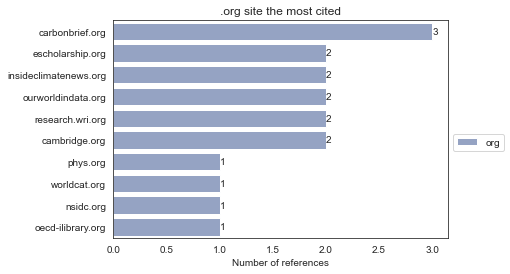

In [18]:
# Plot for .org citations
dorg,dico=sortcitation(df.loc[0,"citationorgtext"],"org")    
plot_site_most_cited(dorg,10,".org site the most cited")

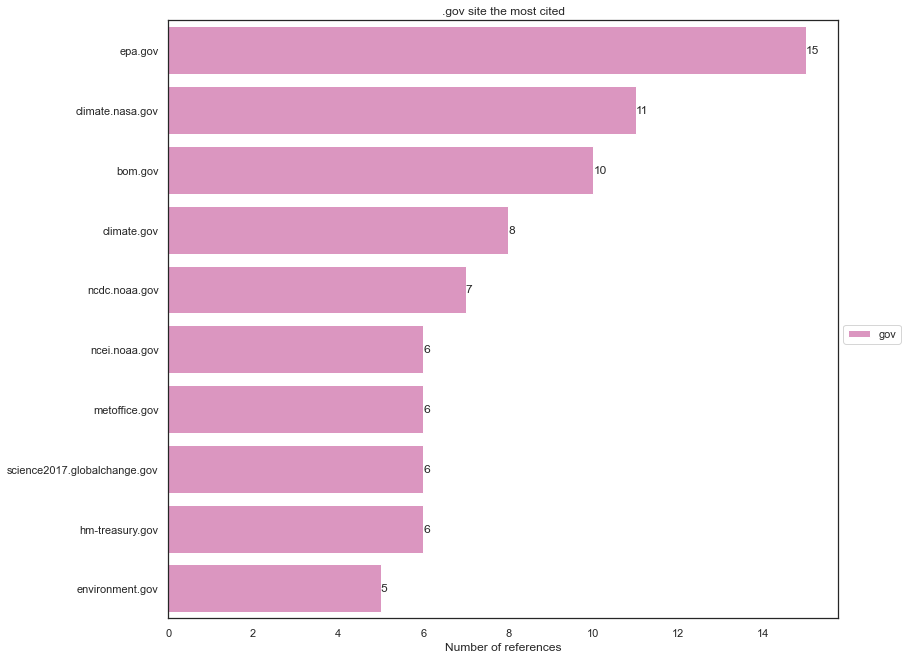

In [19]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"],"gov")
plot_site_most_cited(dfgov,10,".gov site the most cited")

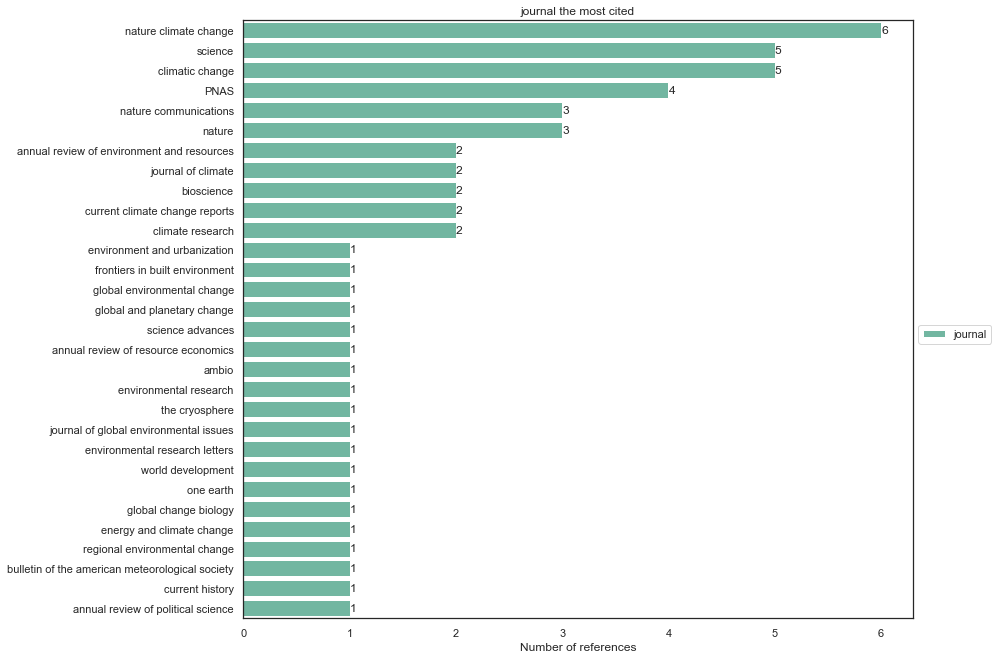

In [20]:
type_of_cit="journal"
#if you want to plot an other type for example .gov you just need to change the name of the column
#the type of cit parameter is not very important
name_column = "journal" #name of the column in which the data is stocked
#Change the name  of the article with the article you want
name_of_article ="Effects of climate change"
dfsci,j=sortcitation(df.loc[df["Name only"]==name_of_article,name_column],type_of_cit)

#plot
dfsci.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(dfsci,30, "journal the most cited")

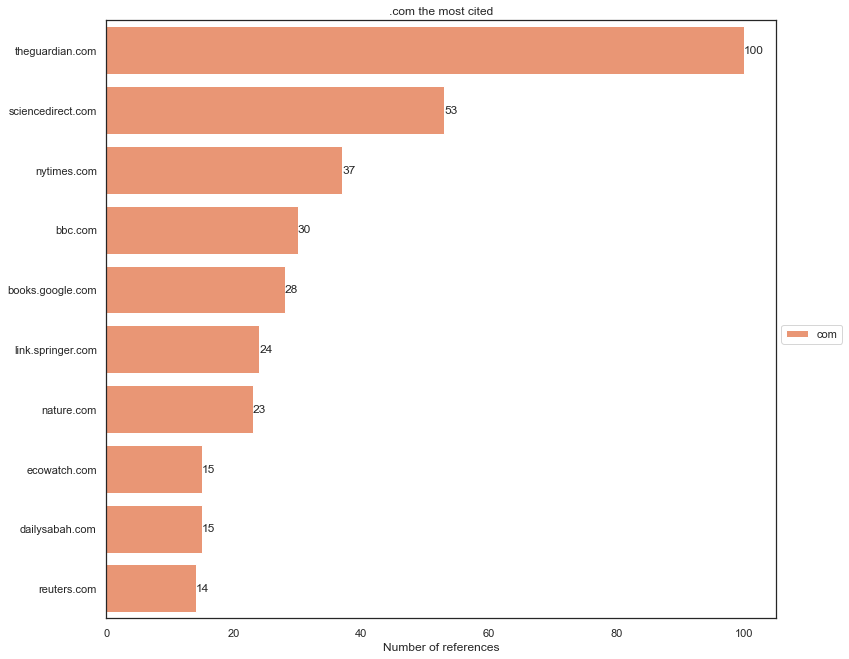

In [21]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"],"com")
plot_site_most_cited(dcom,10, ".com the most cited")

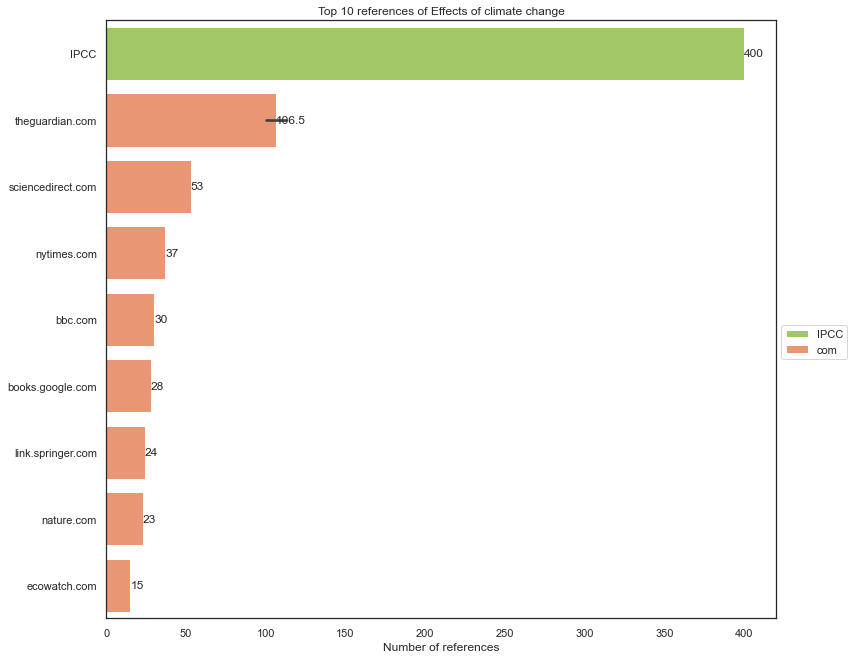

In [22]:
dIg={"name of site": ["IPCC","theguardian.com","biosciences"], "number of times cited":[df.loc[:,"citation IPCC"].sum(), df.loc[:,"citationguardian"].sum(),2], "type": ["IPCC","com","journal"]}
dIg = pd.DataFrame.from_dict(dIg)
big_df = pd.concat([dorg, dfgov,dcom,dfsci,dIg], ignore_index=True)
big_df.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(big_df,10,"Top references")

## Part5. Cleaning the dataframe and scrap of page information

In [23]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [24]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

In [25]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.18it/s]


In [26]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

,Name only,page url,text,citations,Ref count,nb_scientific_citations,journalcitation,journal,nbjournaldetected,citation org,...,Sci count,IPCC count,percentage of official sources,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{good article}}\n{{short description|Effects ...,"{'Ref count': 243, 'Ref': ['{{cite book |last1...",243,325,"[None, None, None, None, None, None, 10.1007/s...","[current climate change reports , proceedings ...",313,36,...,1.337449,0.304527,1.897119,0,Require autoconfirmed or confirmed access (no ...,172751,"15:09, 26 June 2005",Rd232 (talk | contribs),6159,12
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 635, 'Ref': ['{{harvnb|twomey|19...",635,758,"[None, None, 10.1016/j.jclepro.2020.122813, 10...","[journal of cleaner production , science , [[e...",748,49,...,1.193701,0.262992,1.576378,0,Require administrator access (no expiry set),289230,"17:25, 30 October 2001",Zundark (talk | contribs),26243,27
2,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects of climate change ...,"{'Ref count': 151, 'Ref': ['{{cite journal| va...",151,225,"[10.1007/s10584-020-02722-5, None, 10.4324/978...","[climatic change, journal of enology and vitic...",223,24,...,1.490066,0.112583,1.788079,0,Allow all users (no expiry set),119578,"04:31, 13 August 2015",Jarble (talk | contribs),445,23
3,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Environmental history}}\n[...,"{'Ref count': 108, 'Ref': ['{{cite web |title=...",108,169,"[None, 10.1007/s40641-018-0093-2, None, None, ...","[current climate change reports , journal of h...",161,9,...,1.564815,0.083333,1.787037,0,Allow all users (no expiry set),90034,"18:13, 19 September 2012",Ppowers29 (talk | contribs),1470,4
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...,"{'Ref count': 94, 'Ref': ['{{cite journal |las...",94,150,"[10.1073/pnas.0909686107, 10.1111/ecog.02902, ...",[proceedings of the national academy of scienc...,147,9,...,1.595745,0.053191,1.776596,0,Allow all users (no expiry set),64891,"15:56, 11 March 2010",Enescot (talk | contribs),435,0


In [27]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)
df

,Name only,page url,text,citations,Ref count,nb_scientific_citations,journalcitation,journal,nbjournaldetected,citation org,...,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits,Formated DOB,Year_month,Year
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{good article}}\n{{short description|Effects ...,"{'Ref count': 243, 'Ref': ['{{cite book |last1...",243,325,"[None, None, None, None, None, None, 10.1007/s...","[current climate change reports , proceedings ...",313,36,...,0,Require autoconfirmed or confirmed access (no ...,172751,26 June 2005,Rd232,6159,12,2005-06-26,2005-06,2005
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 635, 'Ref': ['{{harvnb|twomey|19...",635,758,"[None, None, 10.1016/j.jclepro.2020.122813, 10...","[journal of cleaner production , science , [[e...",748,49,...,0,Require administrator access (no expiry set),289230,30 October 2001,Zundark,26243,27,2001-10-30,2001-10,2001
2,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects of climate change ...,"{'Ref count': 151, 'Ref': ['{{cite journal| va...",151,225,"[10.1007/s10584-020-02722-5, None, 10.4324/978...","[climatic change, journal of enology and vitic...",223,24,...,0,Allow all users (no expiry set),119578,13 August 2015,Jarble,445,23,2015-08-13,2015-08,2015
3,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Environmental history}}\n[...,"{'Ref count': 108, 'Ref': ['{{cite web |title=...",108,169,"[None, 10.1007/s40641-018-0093-2, None, None, ...","[current climate change reports , journal of h...",161,9,...,0,Allow all users (no expiry set),90034,19 September 2012,Ppowers29,1470,4,2012-09-19,2012-09,2012
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...,"{'Ref count': 94, 'Ref': ['{{cite journal |las...",94,150,"[10.1073/pnas.0909686107, 10.1111/ecog.02902, ...",[proceedings of the national academy of scienc...,147,9,...,0,Allow all users (no expiry set),64891,11 March 2010,Enescot,435,0,2010-03-11,2010-03,2010
5,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Overview of all the effect...,"{'Ref count': 69, 'Ref': ['{{cite web|title=th...",69,112,"[None, None, 10.1093/icesjms/fsu074, 10.1126/s...","[journal of marine science , science , ecologi...",107,8,...,0,Allow all users (no expiry set),72761,21 May 2012,Antblasko,944,3,2012-05-21,2012-05,2012
6,Climate change in Turkey,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Impact of global warming o...,"{'Ref count': 136, 'Ref': ['{{cite news|date=9...",136,155,"[None, None, None, None, None, None, None, Non...","[climate policy, atmospheric research, journal...",153,35,...,0,Allow all users (no expiry set),67195,4 October 2016,Chidgk1,825,2,2016-10-04,2016-10,2016
7,Effects of climate change on the water cycle,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:20211109_Frequency_of_extreme_weather_f...,"{'Ref count': 39, 'Ref': ['{{cite book |last1=...",39,64,"[None, 10.1017/9781009157896.010., 10.1175/202...",[bulletin of the american meteorological socie...,59,4,...,0,Allow all users (no expiry set),39285,18 May 2021,Daanstroeken,165,13,2021-05-18,2021-05,2021
8,Climate change in Australia,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Impacts of climate change ...,"{'Ref count': 201, 'Ref': ['{{cite news|last=k...",201,222,"[None, None, None, None, None, None, None, Non...","[journal of biometeorology, heliyon, journal o...",220,13,...,0,Allow all users (no expiry set),143063,20 November 2007,Mac,1015,1,2007-11-20,2007-11,2007
9,Effects of climate change on livestock,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short descriptio

#### Plot the ratio of page created by a certain editor in our corpus

## Part6. Plot the timeline

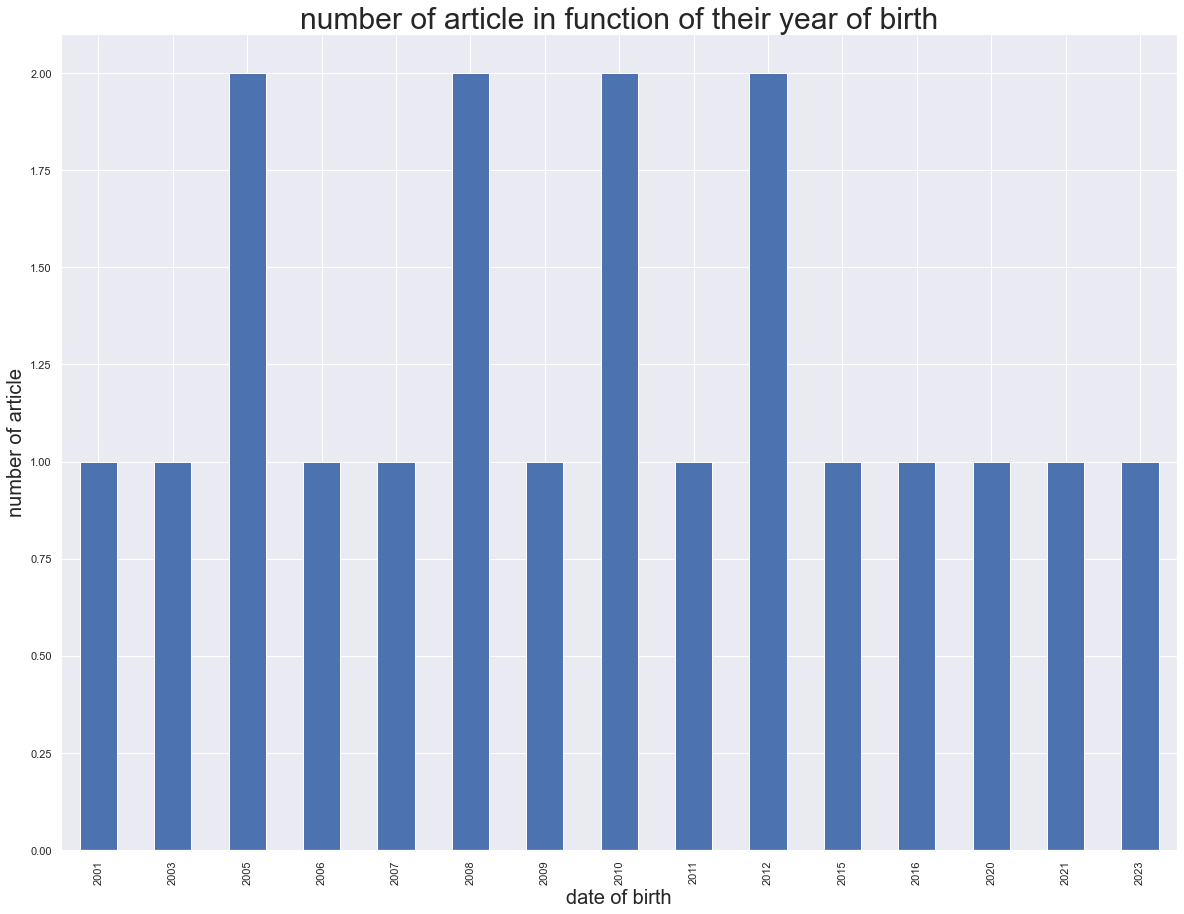

In [28]:
fig = plt.figure(0,figsize=(20,15))
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

## Part7. Clean and export the dataframes to csv

In [ ]:
del df['text'] # delete the column that you don't want to export 

In [29]:
#extract the data frame to csv
TOI = TOI.replace(" ","_") # to remove spaces from name of file
df.to_csv(TOI + '_corpus.csv')